<a href="https://www.kaggle.com/code/aleksandrmorozov123/deep-learning-for-nlp?scriptVersionId=196243873" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Checking statistics of the Corpus**

In [ ]:
# import required libraries
import pandas as pd

# we get first 10 000 values for fast running
ratings = pd.read_csv ('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv')[0:10000]
ratings.info()

In [ ]:
# comparing the text of two selected ratings
print (repr(ratings.iloc[3399]['headline'][0:300]))
print (repr(ratings.iloc[5487]['headline'][0:300]))

In [ ]:
# ignore spaces after the stop words
import re
ratings ["paragraphs"] = ratings ["headline"].map (lambda text: re.split ('[.?!]\s*\n', text))
ratings ['number_of_paragraphs'] = ratings ["paragraphs"].map (len)

**Preparations**

In [ ]:
# import required libraries
import sklearn
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
vectors_text = tfidf_text_vectorizer.fit_transform (ratings ['headline'])
vectors_text.shape

In [ ]:
# flatten the paragraphs keeping the sentiment
paragraph_df = pd.DataFrame ([{'headline': paragraph, 'publisher': publisher}
                             for paragraphs, publisher in \
                             zip (ratings ['paragraphs'], ratings ['publisher'])
                             for paragraph in paragraphs if paragraph])
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform (paragraph_df ['headline'])
tfidf_para_vectors.shape

**Nonnegative matrix factorization** - $ V \approx W \cdot H $

In [ ]:
# import required library
from sklearn.decomposition import NMF

nmf_text_model = NMF (n_components = 10, random_state = 42)
W_text_matrix = nmf_text_model.fit_transform (vectors_text)
H_text_matrix = nmf_text_model.components_

# define a function for outputtin a summary
def display_topics (model, features, no_top_words=5):
    for topic, word_vector in enumerate (nmf_text_model.components_):
        total = word_vector.sum ()
        largest = word_vector.argsort ()[::-1]  # invert sort order
        print ("\ntopic %02d" % topic)
        for i in range (0, no_top_words):
            print ("  %s (%2.2f)" % (features [largest [i]],
                                    word_vector [largest[i]] * 100.0/total))
            
# calling the function
display_topics (nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

In [ ]:
# normalizing topics
W_text_matrix.sum (axis=0)/W_text_matrix.sum()*100.0

**Create a topic model for paragraphs using NMF**

In [ ]:
nmf_para_model = NMF (n_components = 10, random_state = 42)
W_para_matrix = nmf_para_model.fit_transform (tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

display_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out ())

**Latent semantic analysis with singular value decomposition** - any $ m \times n $ matrix V can be decomposed as follows
$V = U \cdot \Sigma \cdot V^* $

In [ ]:
# import required module
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD (n_components = 10, random_state = 42)
W_svd_para_matrix = svd_para_model.fit_transform (tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics (svd_para_model, tfidf_para_vectorizer.get_feature_names_out ())

**Latent Dirichlet Allocation**

In [ ]:
# import required modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_para_vectorizer = CountVectorizer (stop_words=list(STOP_WORDS))
count_para_vectors = count_para_vectorizer.fit_transform (paragraph_df ['headline'])

lda_para_model = LatentDirichletAllocation (n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform (count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics (lda_para_model, tfidf_para_vectorizer.get_feature_names_out ())

**Create Word Clouds to display and compare topic models**

In [ ]:
# import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics (model, features, no_top_words = 40):
    for topic, words in enumerate (model.components_):
        size = {}
        largest = words.argsort ()[::-1]  # invert sort order
        for i in range (0, no_top_words):
            size [features [largest [i]]] = abs (words [largest [i]])
        wc = WordCloud (background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies (size)
        plt.figure (figsize = (12, 12))
        plt.imshow (wc, interpolation = 'bilinear')
        plt.axis ('off')
        
# compare NMF and LDA model
wordcloud_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())
wordcloud_topics (lda_para_model, count_para_vectorizer.get_feature_names_out ())

**Building a neural network using Pytorch**

In [ ]:
# import required libraries
import torch
import torch.nn as nn

x = [[2, 5], [7, 9], [4, 8], [6, 9]]
y = [[4], [9], [12], [17]]

X = torch.tensor (x).float ()
Y = torch.tensor (y).float ()

device = 'cuda' if torch.cuda.is_available () else 'cpu'
X = X.to(device)
Y = Y.to(device)

class MyNeuralNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear (2, 8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear (8, 1)
    def forward (self, x):
        x = self.input_to_hidden_layer (x)
        x = self.hidden_layer_activation (x)
        x = self.hidden_to_output_layer (x)
        return x
    
mynet = MyNeuralNet().to(device)
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func (_Y, Y)
print (loss_value)

In [ ]:
from torch.optim import SGD
import matplotlib.pyplot as plt
%matplotlib inline

opt = SGD (mynet.parameters(), lr = 0.001)

loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func (mynet (X), Y)
    loss_value.backward ()
    opt.step ()
    loss_history.append (loss_value.item())
    
plt.plot(loss_history)
plt.title ('Loss variation over increasing epochs')
plt.xlabel ('epochs')
plt.ylabel ('loss value')

**Resnet block architecture**

In [ ]:
import torch
from torch import nn

class ResLayer (nn.Module):
    def __init__ (self, ni, no, kernel_size, stride=1):
        super (ResLayer, self).__init__()
        padding = kernel_size - 2
        self_conv = nn.Sequential (
        nn.Conv2d (ni, no, kernel_size, stride,
                  padding = padding),
        nn.ReLU ())
        
    def forward (self, x):
        return self.conv (x) + x

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.vgg16(pretrained=True).to(device)
summary(model, torch.zeros(1,3,224,224))

In [ ]:
model

**RNN with TensorFlow**

In [ ]:
import tensorflow as tf
import numpy as np
import re
import os

DATA_DIR = "./data"
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints")

def download_and_read (urls):
    texts = []
    for i, url in enumerate (urls):
        p = tf.keras.utils.get_file ("ex1-{:d}.txt".format (i), url, cache_dir = ".")
        text = open (p, "r").read ()
        # remove byte order mark
        text = text.replace ("\ufeff", "")
        # remove new lines
        text = text.replace ('\n', ' ')
        text = re.sub (r'\s+', " ", text)
        # add it to the list
        texts.extend (text)
    return texts

texts = download_and_read (["http://www.gutenberg.org/cache/epub/28885/pg28885.txt",
"https://www.gutenberg.org/files/12/12-0.txt"])

In [ ]:
# create the vocabulary
vocab = sorted (set (texts))
print ("vocab size: {:d}".format (len(vocab)))

# create mapping from vocab chars to ints
char2idx = {c:i for i, c in enumerate (vocab)}
idx2char = {i:c for c, i in char2idx.items ()}

# numericize the texts
texts_as_ints = np.array ([char2idx[c] for c in texts])
data = tf.data.Dataset.from_tensor_slices (texts_as_ints)

# number of characters to show before asking for prediction sequences: [None, 100]
seq_length = 100
sequences = data.batch (seq_length + 1, drop_remainder = True)

def split_train_labels (sequence):
    input_seq = sequence [0:-1]
    output_seq = sequence [1:]
    return input_seq, output_seq

sequences = sequences.map (split_train_labels)

# set up for training batches: [None, 64, 100]
batch_size = 64
steps_per_epoch = len (texts) // seq_length // batch_size
dataset = sequences.shuffle (10000).batch (batch_size, drop_remainder = True)

In [ ]:
class CharGenModel (tf.keras.Model):
    def __init__ (self, vocab_size, num_timesteps, embedding_dim, **kwargs):
        super (CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding (vocab_size, embedding_dim)
        self.rnn_layer = tf.keras.layers.GRU(
        num_timesteps,
        recurrent_initializer = 'glorot_uniform',
        recurrent_activation = 'sigmoid',
        stateful = True,
        return_sequences = True)
        self.dense_layer = tf.keras.layers.Dense (vocab_size)
        
    def call (self, x):
        x = self.embedding_layer (x)
        x = self.rnn_layer (x)
        x = self.dense_layer (x)
        return x
    
vocab_size = len (vocab)
embedding_dim = 256

model = CharGenModel (vocab_size, seq_length, embedding_dim)
model.build (input_shape = (batch_size, seq_length))

In [ ]:
def loss (labels, predictions):
    return tf.losses.sparse_categorical_crossentropy (
    labels, predictions, from_logits = True)

model.compile (optimizer = tf.optimizers.Adam (), loss = loss)

In [ ]:
def generate_text(model, prefix_string, char2idx, idx2char,
                  num_chars_to_generate=1000, temperature=1.0):
    input = [char2idx[s] for s in prefix_string]
    input = tf.expand_dims(input, 0)
    text_generated = []
    model.reset_states()
    for i in range(num_chars_to_generate):
        preds = model(input)
        preds = tf.squeeze(preds, 0) / temperature
        # predict char returned by model
        pred_id = tf.random.categorical(
            preds, num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[pred_id])
        # pass the prediction as the next input to the model
        input = tf.expand_dims([pred_id], 0)
    return prefix_string + "".join(text_generated)

In [ ]:
num_epochs = 50
for i in range(num_epochs // 10):
    model.fit(
        dataset.repeat(), epochs=10,
        steps_per_epoch=steps_per_epoch
        # callbacks=[checkpoint_callback, tensorboard_callback]
)
    checkpoint_file = os.path.join(CHECKPOINT_DIR, "model_epoch_{:d}".format(i+1))
    model.save_weights(checkpoint_file)
    # create generative model using the trained model so far
    gen_model = CharGenModel(vocab_size, seq_length, embedding_dim)
    gen_model.load_weights(checkpoint_file)
    gen_model.build(input_shape=(1, seq_length))
    print("after epoch: {:d}".format(i+1)*10)
    print(generate_text(gen_model, "Alice ", char2idx, idx2char))
    print("---")

In [ ]:
import nltk
nltk.download("treebank")

def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, "w")
        fposs = open(poss_filename, "w")
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + "\n")
            fposs.write(" ".join([p for w, p in sent]) + "\n")
        fsents.close()
        fposs.close()
    sents, poss = [], []
    with open(sent_filename, "r") as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    with open(poss_filename, "r") as fposs:
        for idx, line in enumerate(fposs):
            poss.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    return sents, poss
sents, poss = download_and_read("./datasets")
assert(len(sents) == len(poss))
print("# of records: {:d}".format(len(sents)))

In [ ]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token="UNK", lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # additional workaround, see issue 8092
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in 
                                tokenizer.word_index.items() if 
                                i <= vocab_size+1 }
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer
word2idx_s, idx2word_s, tokenizer_s = tokenize_and_build_vocab(sents, vocab_size=9000)
word2idx_t, idx2word_t, tokenizer_t = tokenize_and_build_vocab(poss, vocab_size=38, lower=False)
source_vocab_size = len(word2idx_s)
target_vocab_size = len(word2idx_t)
print("vocab sizes (source): {:d}, (target): {:d}".format(
    source_vocab_size, target_vocab_size))

In [ ]:
sequence_lengths = np.array([len(s.split()) for s in sents])
print([(p, np.percentile(sequence_lengths, p))
       for p in [75, 80, 90, 95, 99, 100]])
[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]

In [ ]:
max_seqlen = 271

# convert sentences to sequence of integers
sents_as_ints = tokenizer_s.texts_to_sequences(sents)
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sents_as_ints, maxlen=max_seqlen, padding="post")

# convert POS tags to sequence of (categorical) integers
poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_ints, maxlen=max_seqlen, padding="post")
poss_as_catints = []

for p in poss_as_ints:
    poss_as_catints.append(tf.keras.utils.to_categorical(p,num_classes=target_vocab_size+1, dtype="int32"))
poss_as_catints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_catints, maxlen=max_seqlen)

dataset = tf.data.Dataset.from_tensor_slices(
    (sents_as_ints, poss_as_catints))
idx2word_s[0], idx2word_t[0] = "PAD", "PAD"

# split into training, validation, and test datasets
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10

test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

# create batches
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
        mask = tf.keras.backend.cast(
            tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(
            tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        numer = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy = numer / denom
        return accuracy
    return masked_accuracy_fn

In [ ]:
class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, target_vocab_size,
                 embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(
            source_vocab_size, embedding_dim, input_length=max_seqlen)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation("softmax")
    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x
embedding_dim = 128
rnn_output_dim = 256
model = POSTaggingModel(source_vocab_size, target_vocab_size,
                        embedding_dim, max_seqlen, rnn_output_dim)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", masked_accuracy()])

**Fine-tuning BERT model**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1580k      0 --:--:-- --:--:-- --:--:-- 1580k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   111k      0 --:--:-- --:--:-- --:--:--  111k


In [3]:
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [4]:
df.sample(15)

,sentence_source,label,label_notes,sentence
3840,ks08,1,NaN,the school awarded a few of the girls in miss ...
2877,l-93,1,NaN,i mixed the eggs with cream .
1780,r-67,1,NaN,willy is taller than bill by more than joe is ...
3764,ks08,1,NaN,john gave the cds to the boys .
3080,l-93,0,*,ellen conferred helen .
3329,l-93,1,NaN,on the comer of the two boulevards stood a sta...
4574,ks08,0,*,sam may have been being interrogating by the f...
6365,d_98,1,NaN,a lion is usually majestic .
6059,c_13,1,NaN,"if i were a rich man , i 'd buy a diamond ring ."
1308,r-67,1,NaN,students who fail the final exam will be execu...


In [5]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.sentence_source.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence_source + " [SEP]" for sentence_source in sentences]
labels = df.label.values

# Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'g', '##j', '##0', '##4', '[SEP]']


In [6]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state = 2018, test_size = 0.1)

# Converting all the data into torch tensors
# Torch tensors are the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size = batch_size)

In [7]:
# BERT Model Configuration, initializing a BERT bert-base-uncased style configuration
# Transformer Installation
try:
    import transformers
except:
    print("Installing transformers")
    !pip -qq install transformers
    
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [8]:
# Loading the Hugging Face Bert uncased base model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model = nn.DataParallel(model)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [9]:
# Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have 'gamma' or 'beta' parameters, only 'bias' terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the 'weight' parameters from the 'bias' parameters.
# - For the 'weight' parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the 'bias' parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Displaying a sample of the parameter_optimizer:  layer 3
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]

# Displaying names of parameters for which weight decay is not applied
no_decay

['bias', 'LayerNorm.weight']

In [10]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")
     

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

In [11]:
# the hyperparameters for the training loop\
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [12]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
# the training loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch:   0%|          | 0/4 [00:01<?, ?it/s]


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

**Training evaluation**

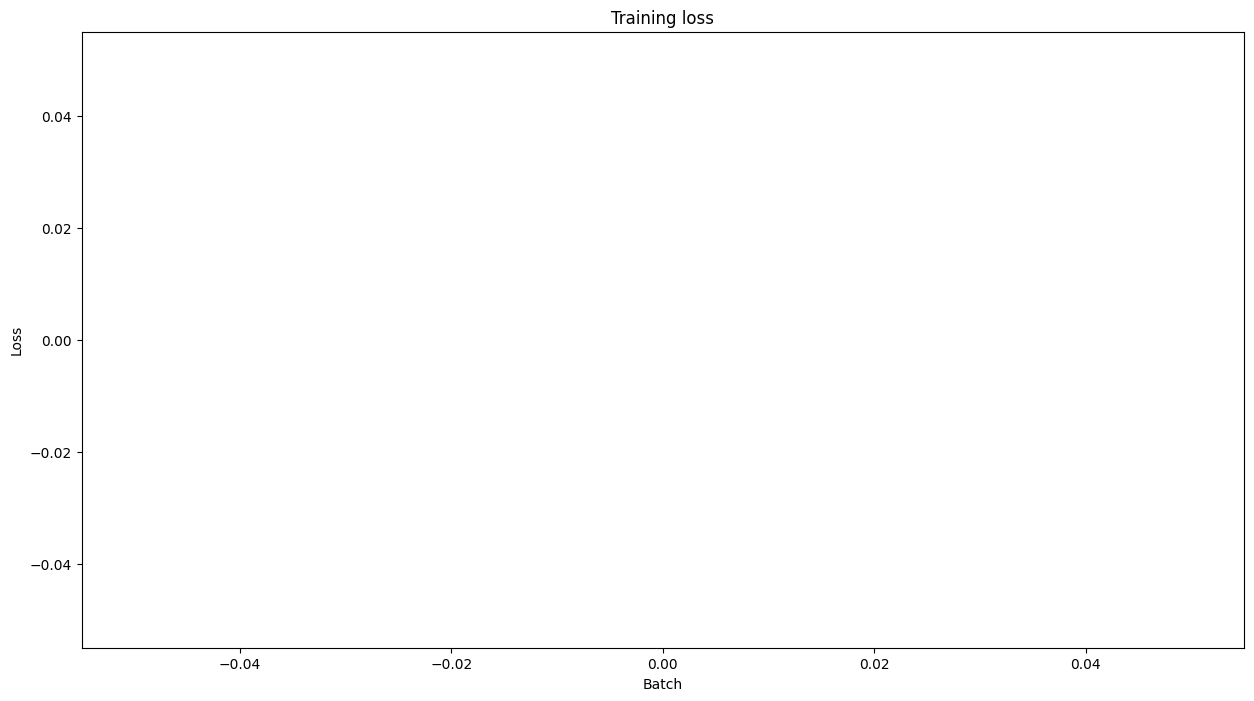

In [14]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()